In [53]:
import plotly.express as px
import pandas as pd
import wmfdata as wmf
from wmfdata.utils import (
    df_to_remarkup,
    pct_str,
    pd_display_all
)

import nshahquinn

In [30]:
nshahquinn.set_plotly_defaults()

# Contributor events

In [2]:
contributor_event = wmf.presto.run("""
SELECT
    FROM_ISO8601_TIMESTAMP(meta.dt) AS dt,
    meta.domain AS domain,
    access_method,
    context_page_title,
    event_type,
    publish_failure_message,
    story_already_exists,
    story_title,
    user_edit_count_bucket,
    user_is_anonymous,
    user_name,
    contribution_attempt_id
FROM event.mediawiki_wikistories_contribution_event
WHERE
    year >= 0
""")

In [ ]:
contributor_event.describe()

Well, this is bizarre! This field was introduced a few weeks ago, so all the null values are expected. The `codfw` and `eqiad` values are not, though.

In [22]:
attempt_id = (
    contributor_event
    ["contribution_attempt_id"]
    .value_counts(dropna=False)
    .head(10)
    .to_frame()
    .reset_index()
    .rename({
        "index": "value",
        "contribution_attempt_id": "frequency"
    }, axis="columns")
)

attempt_id

,value,frequency
0,NaN,1340
1,codfw,1215
2,eqiad,50
3,7d4a499adcd850ec5769,3
4,c8d489b1613f97a9124c,3
5,ce00b7c2a11114e5ea50,2
6,92de0c331e9d2d29fae3,2
7,cdfce631ceeaab2e262c,2
8,03f21bdc208d425b7ffd,2
9,88f3a3f6b6b005c520e8,2


However, if we only look at the data since the start of the deployment of the code setting this field, those weird values go away. That suggests the problem happened after ingestion, not in the instrumentation code.

In [25]:
recent_attempt_id = (
    contributor_event
    .query("dt >= '2022-10-17'")
    ["contribution_attempt_id"]
    .value_counts(dropna=False)
    .head(10)
    .to_frame()
    .reset_index()
    .rename({
        "index": "value",
        "contribution_attempt_id": "frequency"
    }, axis="columns")
)

recent_attempt_id

,value,frequency
0,NaN,27
1,7d4a499adcd850ec5769,3
2,c8d489b1613f97a9124c,3
3,3bd60ed9a56b8fb2fda0,2
4,cdfce631ceeaab2e262c,2
5,65de010762602c8ea53c,2
6,56e1fecbdd705f7ba006,2
7,a6c128c4b0315732fbf5,2
8,92de0c331e9d2d29fae3,2
9,3aa0bd519016f1a5ed58,2


These do seem to be normal events otherwise.

In [ ]:
(
    contributor_event
    .query("contribution_attempt_id in ('codfw', 'eqiad')")
    .sample(10)
    .pipe(pd_display_all)
)

Ahh, it seems like the datacenter field is getting duplicated into this one?

In [33]:
attempt_id_datacenter = wmf.presto.run("""
SELECT
    contribution_attempt_id,
    datacenter
FROM event.mediawiki_wikistories_contribution_event
WHERE
    year >= 0
    AND contribution_attempt_id IN ('codfw', 'eqiad')
""")

In [34]:
attempt_id_datacenter.value_counts(dropna=False)

contribution_attempt_id  datacenter
codfw                    codfw         1215
eqiad                    eqiad           50
dtype: int64

So far, all of the different paths through the funnel that we've recorded look very reasonable.

In [45]:
cai = contributor_event["contribution_attempt_id"].notna()

(
    contributor_event
    .query("dt >= '2022-10-17' & @cai")
    .sort_values("dt")
    .groupby("contribution_attempt_id")
    ["event_type"]
    .agg(lambda s: "-".join(s))
    .value_counts()
)

story_builder_open                                    68
story_builder_open-publish_success                    25
story_builder_open-publish_failure-publish_success     2
Name: event_type, dtype: int64

`story_already_exists` is no longer hardcoded to false.

In [49]:
(
    contributor_event
    .query("dt >= '2022-10-03' & event_type == 'publish_success'")
    ["story_already_exists"]
    .value_counts()
)

False    321
True      40
Name: story_already_exists, dtype: int64

For this sample, the values of `story_already_exists` match the on-wiki history.

In [ ]:
(
    contributor_event
    .query("dt >= '2022-10-03' & event_type == 'publish_success'")
    .sample(10)
    [["dt", "story_title", "user_name", "story_already_exists"]]
)

# Consumer event

In [19]:
consumer_events = wmf.presto.run("""
SELECT
    FROM_ISO8601_TIMESTAMP(meta.dt) AS dt,
    meta.domain AS domain,
    access_method,
    activity_session_id,
    event_type,
    experiment_entry_date,
    experiment_group,
    next_story_opened,
    page_story_count,
    page_title,
    page_visible_time,
    pageview_id,
    referrer_type,
    session_days,
    session_is_first_of_day,
    story_completed,
    story_frame_count,
    story_frames_viewed,
    story_open_time,
    story_title
FROM event.mediawiki_wikistories_consumption_event
WHERE
    year >= 0
""").assign(
    dt=lambda df: pd.to_datetime(df["dt"])
)

In [20]:
consumer_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   dt                       5440 non-null   datetime64[ns, UTC]
 1   domain                   5440 non-null   object             
 2   access_method            5440 non-null   object             
 3   activity_session_id      5440 non-null   object             
 4   event_type               5440 non-null   object             
 5   experiment_entry_date    0 non-null      object             
 6   experiment_group         0 non-null      object             
 7   next_story_opened        0 non-null      object             
 8   page_story_count         5440 non-null   int64              
 9   page_title               5440 non-null   object             
 10  page_visible_time        0 non-null      object             
 11  pageview_id              5440 

In [21]:
consumer_events["event_type"].value_counts()

story_impression    3270
story_view          2170
Name: event_type, dtype: int64

Only story view events have `story_open_time` logged.

In [22]:
(
    consumer_events
    [lambda df: df["story_open_time"].notna()]
    ["event_type"]
    .value_counts()
)

story_view    2170
Name: event_type, dtype: int64

All story_view events have a `story_open_time`.

In [23]:
(
    consumer_events
    .query("event_type == 'story_view'")
    [lambda df: df["story_open_time"].isna()]
)

,dt,domain,access_method,activity_session_id,event_type,experiment_entry_date,experiment_group,next_story_opened,page_story_count,page_title,page_visible_time,pageview_id,referrer_type,session_days,session_is_first_of_day,story_completed,story_frame_count,story_frames_viewed,story_open_time,story_title


Successive story open times within the same pageview do not always increase, which means the `story_open_time` is calculated indepedently for each story rather than being cumulative. I will have to note that in the schema documentation.

In [24]:
(
    consumer_events
    .query("event_type == 'story_view'")
    .assign(story_open_time=lambda df: (df["story_open_time"] / 1000).round().astype(int))
    .sort_values("dt")
    .groupby("pageview_id")
    ["story_open_time"]
    .agg(lambda s: ", ".join(s.astype(str)))
    .sample(25)
)

pageview_id
1ecd7c4602afd7281e1b                   22
7d9fdf5fdf4601b3ccc8       16, 2, 8, 4, 6
38653ffac51dbb4c6539                    2
737af27a80c19c9acd28                    6
ab32b01f4615763fa4f3                   20
03cb9ac6da5c6ffb67dd                   32
9da76786fd339c4d3423                   62
90c3cafec1e30eb80de7                14, 1
18a15976b528bf403862                   19
765341440f7c30d1af28                    2
09acedd452d01b87b53e                    4
f8200d61a49e0aa2b41d                   23
19bdd1405b4ccf12b823             9, 10, 3
217148c727f2da2b2bdd                  612
f86b79c1b6e3ed4f67fc    2, 11, 3, 6, 2, 2
3cf81929d85943f9b37c                    3
b7d4e7e3bcbc5fb7c00b                    2
0e4e412016192023e322            27, 8, 50
5a255b3c0a302531636f                    9
2d0bfcf97680d63fa6cd                   52
b0bd792897add400c739                11, 5
e397650769d80bad4c5f           10, 14, 10
27ffd3bb641f7f2f23e5                    7
bacfe029f872e869e7a5  

In [25]:
consumer_events["page_title"].value_counts()

Museum_Sejarah_Jawa                      314
Museum_Sonobudoyo                        235
Museum_Pusat_TNI_AD_"Dharma_Wiratama"    161
Kekhalifahan_Rasyidin                    159
Kucing                                   149
                                        ... 
Jalangkote                                 1
Ki_Hadjar_Dewantara                        1
Grotta_Azzurra                             1
Stasiun_Padang                             1
Max_Verstappen                             1
Name: page_title, Length: 433, dtype: int64

In [26]:
consumer_events["page_story_count"].describe()

count    5440.000000
mean        2.798346
std         2.671504
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max        10.000000
Name: page_story_count, dtype: float64

In [31]:
session = (
    consumer_events
    .groupby("activity_session_id")
    .agg(
        approx_duration=("dt", lambda s: s.max() - s.min()),
        event_count=("event_type", len)
    )
)

session

,approx_duration,event_count
activity_session_id,,
00449fb54cdfc66e06fb,0 days 00:01:09.299000,5
00cd0987f3d0a3b7f52d,0 days 00:09:00.608000,5
00dba6ed58073c6b8123,0 days 00:00:11.468000,2
0130caa004897bdc6ec1,0 days 00:01:30.690000,5
01383c2cc1d7dd237482,0 days 00:23:48.996000,6
...,...,...
fe4ab0175441b1f25c31,0 days 00:00:00,1
febb152173ac36ecea73,0 days 00:00:59.464000,4
fed835a5f50e11629c65,0 days 00:01:47.813000,4


Wow, there are some absurdly long sessions here.

In [34]:
session.sort_values("approx_duration", ascending=False).head(10)

,approx_duration,event_count
activity_session_id,,
2be8a42c168afdf1742f,2 days 07:20:38.820000,5
2868f147b58768904032,1 days 05:31:53.321000,2
4b303608167e150238e4,1 days 00:59:31.688000,13
fa25dfab2b66bbcab9c2,0 days 21:30:48.003000,34
8aece4d26321cd14b424,0 days 09:03:21.214000,5
fa7915e190bdeeb98cfe,0 days 08:37:44.958000,18
46c6dd8e1e47b921fabc,0 days 06:59:10.050000,2
746c3672b6948efc94cf,0 days 05:47:38.344000,11
b7f9cb894560bc3c8337,0 days 05:20:11.344000,2


Having inspected the first 8 in depth, they all follow the same pattern: all but one event in very plausible span of time (about 30 minutes or less), and then a final event many hours later. The page of the final event is usually but not always a page that has appeared previously in the session. At least a couple of these session seem to include a story creation, since they involve multiple `story_impression` and `story_view` events on the same page with an increase in the `page_story_count`.

What's the best cutoff between a likely-real long session and a likely-mistake long session? All the longest sessions, at 6 hours duration or up, seemed like mistakes. Sampling five sessions between 2 hours and 5 hours long, the first two (at 2 hr, 3 min and 2 hr, 11 min) seemed to be real, with lots of events spread evenly throughout the duration. Both seemed to involve users creating stories. The last three (at 2 hr, 31 min, 2 hr, 28 min, and 3 hr, 3 min) seem like errors, following the pattern of a single event hours after an initial cluster. Based on this, we can conservatively say that sessions longer than 2 hr, 30 min are likely errors.

In [70]:
long_session[lambda df: df["approx_duration"] < "5 hour"].sample(5)

,approx_duration,event_count
activity_session_id,,
f08f96955a5dc64eb83c,0 days 02:02:54.069000,18
8b84867f64e0b62717d7,0 days 02:10:55.192000,30
3396c599e245b5d4c067,0 days 02:30:58.676000,4
5649e2034d305dba0350,0 days 02:27:33.601000,5
64e7c82eef4f1a9c6461,0 days 03:02:08.033000,4


Long sessions like this make up a surprisingly large propotion of the total.

In [77]:
long_session = session[lambda df: df["approx_duration"] >= "2 hr, 30 min"]

print(pct_str(len(long_session) / len(session)))

3.1%


Under our cutoff, the distribution of session lengths seems quite reasonable.

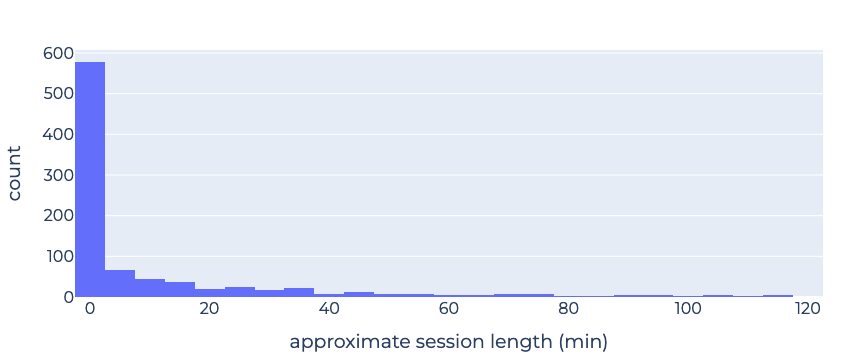

In [67]:
short_session = (
    session
    .drop(long_session.index)
    .assign(
        approx_duration=lambda df: df["approx_duration"].dt.seconds / 60
    )
)

px.histogram(
    short_session,
    x="approx_duration",
    labels={"approx_duration": "approximate session length (min)"}
)